In [1]:
import os
import numpy as np
from uncertainty_motion_prediction.dataloader import Dataloader
import matplotlib.pyplot as plt

dataset=Dataloader();
traj_dataset = dataset.load(0)

# Get trajectories from the dataset

## As a list of Pandas dataframes

In [2]:
trajlets = traj_dataset.get_trajlets(length=4.8)
len(trajlets)

768

## As numpy array

In [3]:
trajlets = traj_dataset.get_trajlets(length=4.8, to_numpy=True)
trajlets[0, :, :]

array([[13.017548  ,  5.7825914 , -2.3244442 , -0.07660594, 53.6       ],
       [12.08777   ,  5.751949  , -1.5890517 , -0.06597106, 54.        ],
       [11.746306  ,  5.7298146 , -1.1407656 ,  0.10537256, 54.4       ],
       [11.175158  ,  5.8362471 , -1.6400209 ,  0.17923528, 54.8       ],
       [10.43429   ,  5.8732028 , -1.4061292 ,  0.41904965, 55.2       ],
       [10.050254  ,  6.1714868 , -1.0787423 ,  0.45518986, 55.6       ],
       [ 9.5712958 ,  6.2373547 , -1.207725  ,  0.11543663, 56.        ],
       [ 9.0840742 ,  6.2638361 , -1.2731811 ,  0.17084078, 56.4       ],
       [ 8.5527509 ,  6.3740273 , -1.2327335 ,  0.2715015 , 56.8       ],
       [ 8.0978874 ,  6.4810373 , -1.1467297 ,  0.21789191, 57.2       ],
       [ 7.6353672 ,  6.5483408 , -1.1634956 ,  0.16930578, 57.6       ],
       [ 7.1670909 ,  6.616482  , -1.1264929 ,  0.11639996, 58.        ]])

# Kalman filter predictor using Constant Velocity model

Instantiate the Kalman filter using the Constant Velocity model, and perform some sanity checks.

In [4]:
from uncertainty_motion_prediction.evaluators import DistanceErrorEvaluator
from uncertainty_motion_prediction.predictor import ConstantVelocityKFPredictor

In [5]:
pred = ConstantVelocityKFPredictor(N_future=4, dt=0.4)
test_traj1 = [[1, 1, 1, 0],
              [1.4, 1, 1.1, 0.1],
              [1.8, 1, 1.3, 0]]
test_traj2 = [[1.1, 1, 0, 1],
              [0.9, 1.4, 0, 1],
              [1.2, 1.8, 0, 1]] # inject some noise into the x-position
predicted_traj = pred.predict_batch(np.array([test_traj1, test_traj2]))
print(predicted_traj[:, :, 0:2])

[[[2.37978401 1.02624203]
  [2.89188114 1.02689916]
  [3.40397828 1.02755628]
  [3.91607541 1.02821341]]

 [[1.06661583 2.2       ]
  [1.06661583 2.6       ]
  [1.06661583 3.        ]
  [1.06661583 3.4       ]]]


# Evaluate ADE and FDE

Constant velocity predictor requires no training, hence there is no need to split the trajectories into train and validation sets.

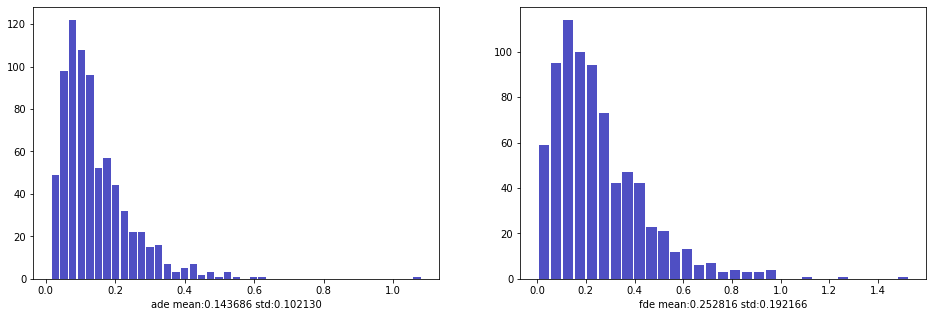

In [6]:
pred = ConstantVelocityKFPredictor(N_future=4,dt=0.4)
evaluator = DistanceErrorEvaluator(N_future=4)
evaluator.evaluate(pred, trajlets)
evaluator.hist()
res_state = evaluator.statistic()

# Visualize distribution of future trajectories

In [7]:
from uncertainty_motion_prediction.visualizer import SamplingVisualizer

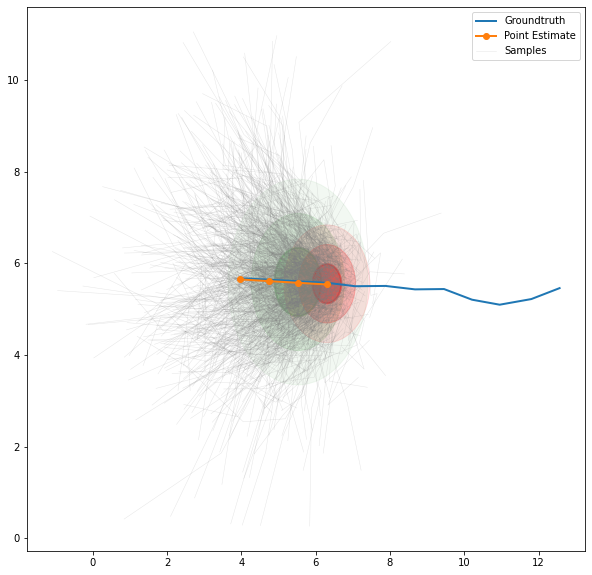

In [8]:
import matplotlib.pyplot as plt

pred = ConstantVelocityKFPredictor(N_future=4, dt=0.4)
viz = SamplingVisualizer(N_future=4, sample_size=1000)
fig, axs = plt.subplots(1, 1, figsize=(10, 10))

traj = trajlets[90, :, :]
viz.visualize_to_axis(axs, pred, traj)

## Optimization on Q
Considering the dynamics constraint bewtween $v$ and $p$
## Optimization on R
Gaussian assumption on the velocity of $x$ and $y$, MLE to estimate variance

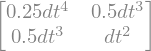

In [9]:
from sympy import Symbol, Matrix
from sympy.interactive import printing
printing.init_printing()
dts = Symbol('dt')
Qs = Matrix([[0.5*dts**2],[dts]])
Qs*Qs.T

## Baseline

In [10]:
Q = np.eye(4) * 0.05
R = np.eye(4) * 0.05
pred = ConstantVelocityKFPredictor(N_future=4, dt=0.4, Q=Q, R=R)
evaluator = DistanceErrorEvaluator(N_future=4)
evaluator.evaluate(pred, trajlets)
baseline = evaluator.statistic()

In [11]:
pred = ConstantVelocityKFPredictor(N_future=4, dt=0.4, R=R)
evaluator = DistanceErrorEvaluator(N_future=4)
evaluator.evaluate(pred, trajlets)
q_opt = evaluator.statistic()

In [12]:
pred = ConstantVelocityKFPredictor(N_future=4, dt=0.4, Q=Q)
evaluator = DistanceErrorEvaluator(N_future=4)
evaluator.evaluate(pred, trajlets)
r_opt = evaluator.statistic()

<BarContainer object of 4 artists>

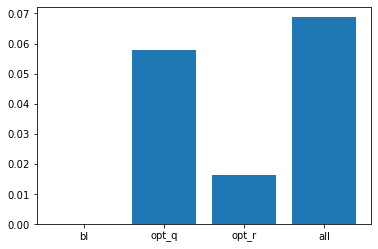

In [13]:
m = 'ade'
x = ['bl', 'opt_q', 'opt_r', 'all']
y = np.array([baseline[m][0], q_opt[m][0],r_opt[m][0],res_state[m][0]])
y = (baseline[m][0]/y - 1)

plt.bar(x, y)